In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Step 1: Load and Preprocess Data
data = pd.read_csv('30_day_traffic.csv', parse_dates=['timestamp'])
data.set_index('timestamp', inplace=True)

# Check for missing timestamps
expected_freq = '1min'
missing_times = pd.date_range(start=data.index.min(), end=data.index.max(), freq=expected_freq).difference(data.index)
print(f"Missing timestamps: {len(missing_times)}")  # Should be 0 for continuous data

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data['http_requests_scaled'] = scaler.fit_transform(data[['http_requests']])

# Add time features
data['hour'] = data.index.hour
data['minute'] = data.index.minute
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
data['minute_sin'] = np.sin(2 * np.pi * data['minute'] / 60)
data['minute_cos'] = np.cos(2 * np.pi * data['minute'] / 60)

# Define features to use
features = ['http_requests_scaled', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos']

# Function to create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, 0])  # Predict the next HTTP request value
    return np.array(X), np.array(y)

# Parameters
window_size = 360  # 
 # 

# Prepare training data
X, y = create_sequences(data[features].values, window_size)

# Split into train and test (e.g., 80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(window_size, len(features))))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Missing timestamps: 0


/home/mohsin/Documents/notebookvirtual/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 68s 62ms/step - loss: 0.0203 - val_loss: 0.0157
Epoch 2/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 62s 58ms/step - loss: 0.0157 - val_loss: 0.0118
Epoch 3/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 62s 58ms/step - loss: 0.0117 - val_loss: 0.0106
Epoch 4/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 63s 58ms/step - loss: 0.0109 - val_loss: 0.0096
Epoch 5/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 62s 58ms/step - loss: 0.0099 - val_loss: 0.0109
Epoch 6/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 63s 58ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 7/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 63s 59ms/step - loss: 0.0095 - val_loss: 0.0095
Epoch 8/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 63s 58ms/step - loss: 0.0096 - val_loss: 0.0092
Epoch 9/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 63s 59ms/step - loss: 0.0094 - val_loss: 0.0089
Epoch 10/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 63s 59ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 11/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 63s 59ms/step - loss: 0.0087 - val_loss: 0.0111
Epoch 12

In [42]:
model.save("model_1.keras")
from tensorflow.keras.models import load_model
model= load_model('model_1.keras')

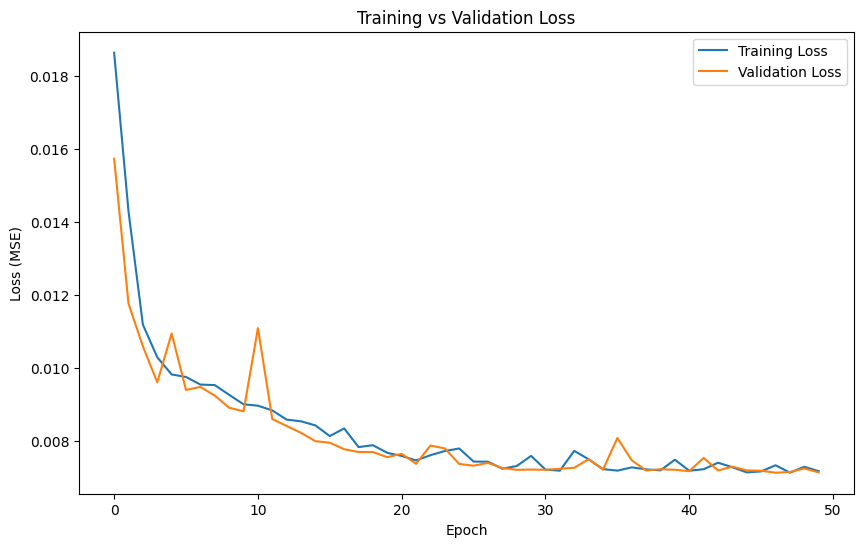

Test Loss (MSE): 0.007140824105590582
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
MAE: 61.77, RMSE: 71.74


In [25]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Evaluate the model on test data
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss (MSE): {test_loss}')

# Predictions on test data
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate regression metrics
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'MAE: {mae:.2f}, RMSE: {rmse:.2f}')

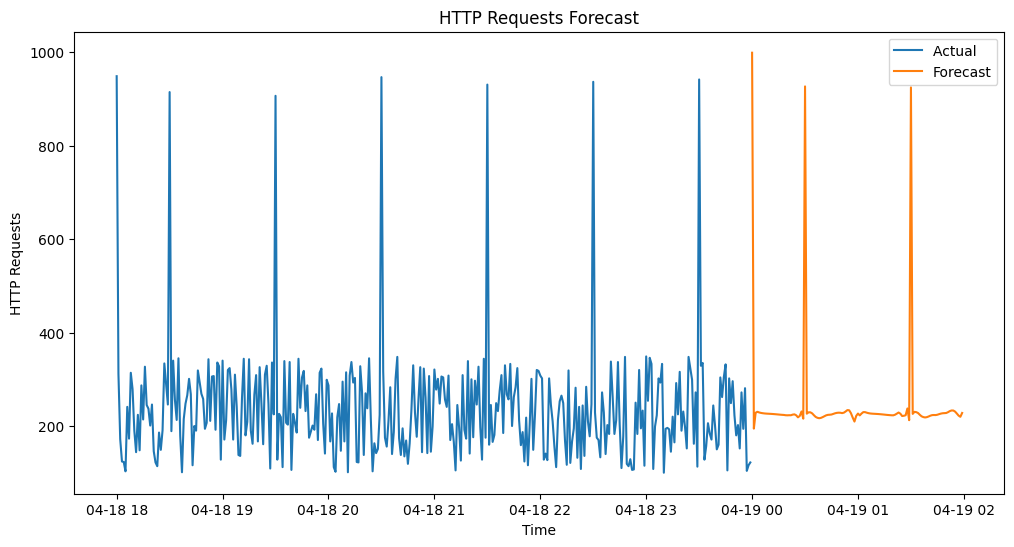

In [40]:
forecast_steps = 120
# Modified forecast function
def forecast(model, data, window_size, steps, last_timestamp):
    predictions = []
    current_data = data[-window_size:].copy()  # Shape: (window_size, 5)
    current_time = last_timestamp
    
    for _ in range(steps):
        # Predict the next value
        current_input = current_data.reshape((1, window_size, len(features)))
        pred = model.predict(current_input, verbose=0)[0, 0]
        predictions.append(pred)
        
        # Update time features for the next step
        current_time += pd.Timedelta(minutes=1)
        hour = current_time.hour
        minute = current_time.minute
        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        minute_sin = np.sin(2 * np.pi * minute / 60)
        minute_cos = np.cos(2 * np.pi * minute / 60)
        
        # Shift the window and append the new data point
        new_row = np.array([pred, hour_sin, hour_cos, minute_sin, minute_cos])
        current_data = np.concatenate((current_data[1:], new_row.reshape(1, -1)), axis=0)
    
    return np.array(predictions)

last_24_hours = data[features].values[-360:]  # Last 24 hours
last_timestamp = data.index[-1]
forecasted_values = forecast(model, last_24_hours, window_size, forecast_steps, last_timestamp)

# Inverse transform the forecasted values
forecasted_values_inv = scaler.inverse_transform(forecasted_values.reshape(-1, 1))

# Plot Forecast
actual_last_24 = data['http_requests'].values[-360:]
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(minutes=1), periods=forecast_steps, freq='1min')

plt.figure(figsize=(12, 6))
plt.plot(data.index[-360:], actual_last_24, label='Actual ')
plt.plot(forecast_index, forecasted_values_inv, label='Forecast')
plt.title('HTTP Requests Forecast')
plt.xlabel('Time')
plt.ylabel('HTTP Requests')
plt.legend()
# plt.savefig('forecast.png')
plt.show()

In [29]:
model.save("model_1.keras")

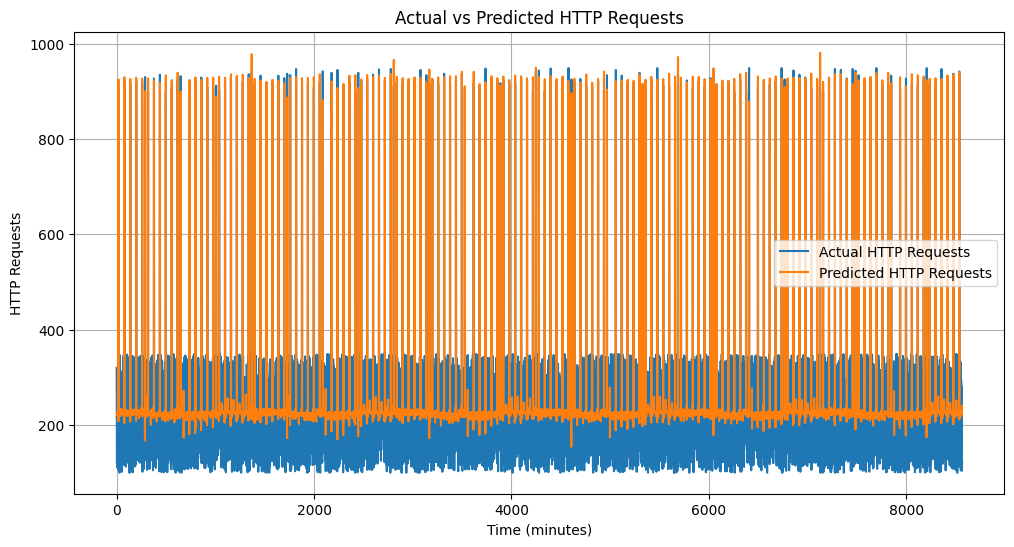

In [30]:
# Convert the data to a DataFrame for easier plotting
df1 = pd.DataFrame({
    'Actual': y_test_inv.flatten(),  # Flatten to ensure it's 1D for plotting
    'Predicted': y_pred_inv.flatten()  # Flatten to ensure it's 1D for plotting
})

# Plot Actual vs Predicted (first 500 data points for clarity)
plt.figure(figsize=(12, 6))
plt.plot(df1['Actual'], label='Actual HTTP Requests')  # Plot first 500 for clarity
plt.plot(df1['Predicted'], label='Predicted HTTP Requests')
plt.title('Actual vs Predicted HTTP Requests')
plt.xlabel('Time (minutes)')
plt.ylabel('HTTP Requests')
plt.legend()
plt.grid(True)

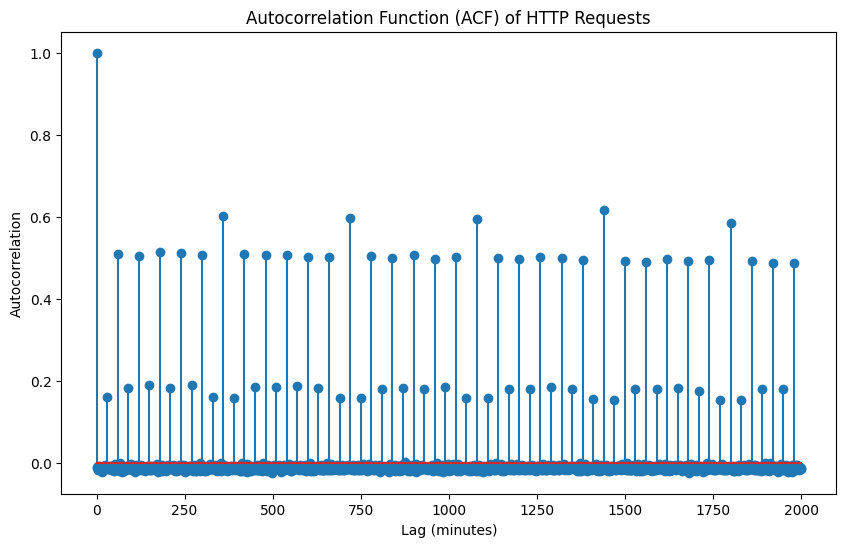

Suggested window_size: 2 minutes


In [17]:
# import pandas as pd
# import numpy as np
# from statsmodels.tsa.stattools import acf
# import matplotlib.pyplot as plt

# # Load data
# df = pd.read_csv('30_day_traffic.csv', parse_dates=['timestamp'], index_col='timestamp')
# series = df['http_requests']

# # Compute ACF up to 2000-minute lag
# max_lag = 2000
# acf_values = acf(series, nlags=max_lag, fft=True)
# lags = np.arange(len(acf_values))

# # Plot the ACF (removed use_line_collection)
# plt.figure(figsize=(10, 6))
# plt.stem(lags, acf_values)
# plt.xlabel('Lag (minutes)')
# plt.ylabel('Autocorrelation')
# plt.title('Autocorrelation Function (ACF) of HTTP Requests')
# plt.show()

# # Suggest a window_size: first non-zero lag where ACF < 0.2
# threshold = 0.2
# below_threshold = np.where(acf_values < threshold)[0]
# if len(below_threshold) > 1:
#     suggested = below_threshold[1]  # skip lag 0
#     print(f"Suggested window_size: {suggested} minutes")
# else:
#     print(f"No lag < {threshold} found within {max_lag} minutes.")
